## Задание 1. Радиальная функция распределения

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

Спарсим условия симуляции:

In [33]:
rho = [0.001, 0.7]
number_of_particles = int(open("dump_0.001/200.xyz").readline())
box_size = defaultdict(float)
for r in rho: box_size[r] = float(open(f"dump_{r}/200.xyz").readlines()[1].split()[1])

Парсим `.xyz` файлы:

In [ ]:
xyz = defaultdict(list)
for r in rho:
    paths = [f'dump_{r}/{i}.xyz' for i in np.arange(200, 20000, 200)]
    xyz[r] = [pd.DataFrame([line.split()
                        for line in open(path).readlines()[2:]]).drop(labels=[3, 4, 5], axis=1)
                        for path in paths]             
    for df in xyz[r]: df.columns = ['x', 'y', 'z']

Объявляем функцию для расчета расстояния между частицами с учетом Minimal image convention:

In [34]:
def calculate_distance(p1: np.array, p2: np.array, box_size: float):
    dist = p2 - p1
    for i in range(dist.shape[0]):
        if (dist[i] > box_size/2):
            dist[i] -= box_size
        elif (dist[i] < -box_size/2):
            dist[i] += box_size
    return np.linalg.norm(dist)

Теперь найдем `rdf` для последнего фрейма (можем получить данные для нескольких фреймов, если хотим):

In [37]:
rdf = defaultdict(np.array)
for r in rho:
    rdf[r] = np.array([[[calculate_distance(df.iloc[i].to_numpy().astype(float), df.iloc[k].to_numpy().astype(float), box_size[r])
                        for i in range(number_of_particles) if i!=k]
                        for k in range(number_of_particles)]
                        for df in [xyz[r][-1]]])

Объявим функцию для построения графика `rdf` (построим гистограмму для каждого фрейма и частицы и усредним):

In [38]:
def rdf_plot(rdf: np.array, bins: int, rho: float):
    hist = []
    box_size1 = box_size[rho]
    max = ((box_size1 / 2)**2 * 3)**0.5

    # Построим гистограмму для каждой частицы и каждого фрейма
    for k in range(rdf.shape[0]):
        for i in range(rdf.shape[1]):
            hist.append(np.histogram(rdf[k, i], bins=bins, range=[0, max])[0])

    hist = np.array(hist)

    bins = np.histogram(rdf[0, 0], bins=bins, range=[0, max])[1]
    r = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0]-1)]
    dr = bins[1] - bins[0]

    hist_mean = np.mean(hist, axis=0)
    hist_rdf = [hist_mean[i] / (4 * np.pi * bins[i]**2 * dr * rho) for i in range(hist_mean.shape[0])]

    plt.plot(r, hist_rdf)
    plt.hlines(1, 0, max, 'r')

График для плотности 0.001 и температуры 1.0 (газ):

/tmp/ipykernel_3349293/3373583373.py:16: RuntimeWarning: invalid value encountered in scalar divide
  hist_rdf = [hist_mean[i] / (4 * np.pi * bins[i]**2 * dr * rho) for i in range(hist_mean.shape[0])]


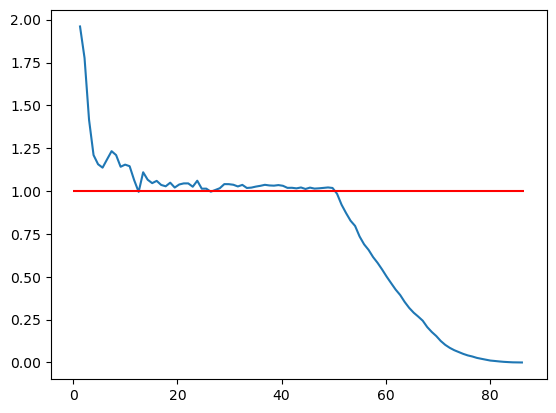

In [42]:
rdf_plot(rdf[0.001], 100, 0.001)

График для плотонсти 0.7 и температуры 1.0 (жидкость):

/tmp/ipykernel_3349293/3373583373.py:16: RuntimeWarning: invalid value encountered in scalar divide
  hist_rdf = [hist_mean[i] / (4 * np.pi * bins[i]**2 * dr * rho) for i in range(hist_mean.shape[0])]


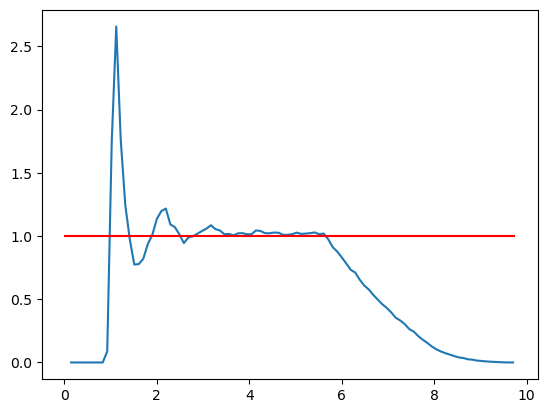

In [43]:
rdf_plot(rdf[0.7], 100, 0.7)